In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import squarify
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import datetime
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import pycountry

In [2]:
data_set = pd.read_csv('C:/Users/Shiwani Sabnis/PycharmProjects/Data Warehouse/New Test/Online Retail.csv')

In [3]:
data_set

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [4]:
#finding out NANs in the table in order to treat them for better results
data_set.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
data_set.dropna(subset=['Description', 'CustomerID'],axis=0,inplace=True)

In [6]:
data_set.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
data_set.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [8]:
conn = sqlite3.connect("RFMdb")
cur = conn.cursor() 

In [9]:
data_set.to_sql("data_set", conn)

In [10]:
cleandata_set= pd.read_sql(''' SELECT customerid,
                   MAX(invoicedate) AS last_order_date,
                   COUNT(*) AS count_order,
                   SUM(unitprice*quantity) AS totalprice
            FROM data
            WHERE InvoiceNo NOT LIKE '%C%'
            AND customerid IS NOT NULL
            AND unitprice != 0
            GROUP BY customerid ''', conn)

In [11]:
cleandata_set.to_sql("cleandata_set", conn)

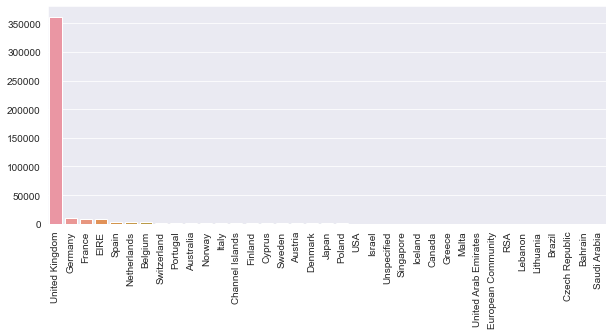

In [12]:
Country = data_set.Country.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=Country.index, y=Country.values)
plt.xticks(rotation='vertical')
plt.show()

In [13]:
data_set.drop(data_set.index[data_set['Country'] == 'United Kingdom'], inplace = True)

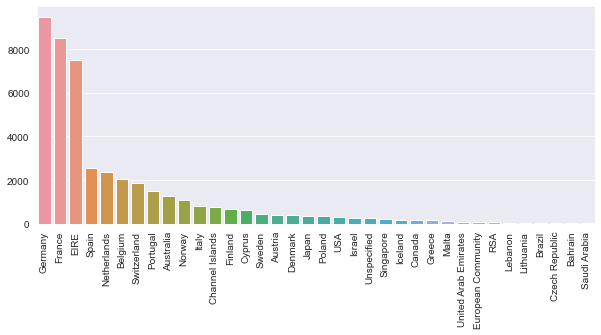

In [14]:
Country = data_set.Country.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=Country.index, y=Country.values)
plt.xticks(rotation='vertical')
plt.show()

In [15]:
# total quantity of products have been sold online from each country

data_set['Quantity'].groupby(data_set['Country']).agg('sum')

Country
Australia                83653
Austria                   4827
Bahrain                    260
Belgium                  23152
Brazil                     356
Canada                    2763
Channel Islands           9479
Cyprus                    6317
Czech Republic             592
Denmark                   8188
EIRE                    136329
European Community         497
Finland                  10666
France                  109848
Germany                 117448
Greece                    1556
Iceland                   2458
Israel                    3990
Italy                     7999
Japan                    25218
Lebanon                    386
Lithuania                  652
Malta                      944
Netherlands             200128
Norway                   19247
Poland                    3653
Portugal                 16044
RSA                        352
Saudi Arabia                75
Singapore                 5234
Spain                    26824
Sweden                   35637


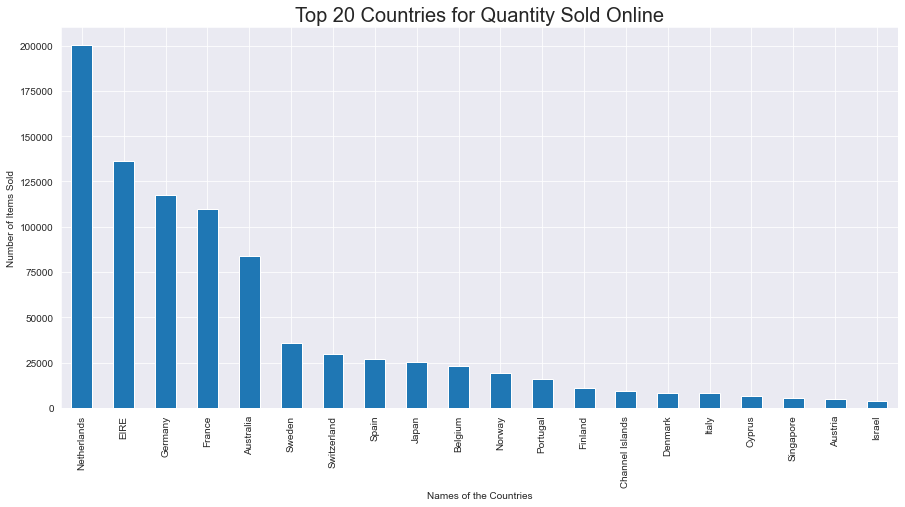

In [16]:
# Top 20 Countries in terms of Quantities according to the countries

data_set['Quantity'].groupby(data_set['Country']).agg('sum').sort_values(ascending = False).head(20).plot.bar(figsize = (15, 7))

plt.title('Top 20 Countries for Quantity Sold Online', fontsize = 20)
plt.xlabel('Names of the Countries')
plt.ylabel('Number of Items Sold')
plt.show()

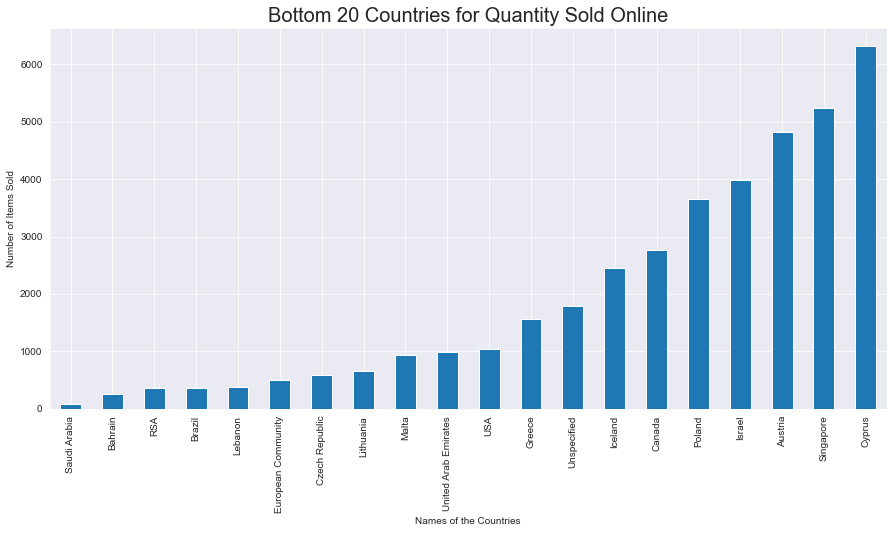

In [17]:
#bottom 20 Countries in terms of Quantities according to the countries

data_set['Quantity'].groupby(data_set['Country']).agg('sum').sort_values(ascending = True).head(20).plot.bar(figsize = (15, 7))

plt.title('Bottom 20 Countries for Quantity Sold Online', fontsize = 20)
plt.xlabel('Names of the Countries')
plt.ylabel('Number of Items Sold')
plt.show()

C:\Users\Shiwani Sabnis\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


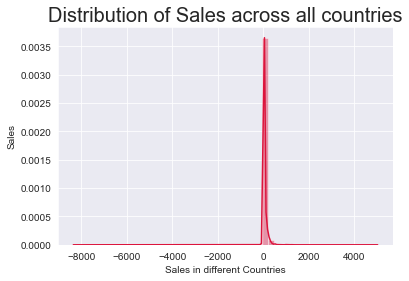

In [18]:
# sales = unitprice * quantity

data_set['Sales'] = data_set['UnitPrice'] * data_set['Quantity']

# visualizing the sales 
sns.distplot(data_set['Sales'], color = 'crimson')
plt.title('Distribution of Sales across all countries', fontsize = 20)
plt.xlabel('Sales in different Countries')
plt.ylabel('Sales')
plt.show()

In [19]:
data_set = pd.read_sql(''' SELECT customerid, rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined 
    FROM 
     ( SELECT customerid, 
             NTILE(4) OVER (ORDER BY last_order_date) AS rfm_recency,
             NTILE(4) OVER (ORDER BY count_order) AS rfm_frequency,
             NTILE(4) OVER (ORDER BY totalprice) AS rfm_monetary
      FROM 
            cleandata
            ) 
 ''', conn)
data_set

,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,17356.0,1,2,1,121
1,14850.0,1,2,2,122
2,13494.0,1,2,2,122
3,12929.0,1,1,1,111
4,12373.0,1,1,2,112
...,...,...,...,...,...
4333,15329.0,4,3,3,433
4334,12417.0,4,4,4,444
4335,15977.0,4,3,3,433
4336,13982.0,4,4,4,444


In [20]:
#finding out NANs in the table in order to treat them for better results
data_set.isna().sum()

customerid       0
rfm_recency      0
rfm_frequency    0
rfm_monetary     0
rfm_combined     0
dtype: int64

In [21]:
def rfm_level(data_set):
    if ((data_set['rfm_recency'] >= 4) and (data_set['rfm_frequency'] >= 4) 
        and (data_set['rfm_monetary'] >= 4)):
        return 'Best Customers'
    elif ((data_set['rfm_recency'] >= 3) and (data_set['rfm_frequency'] >= 3)
          and (data_set['rfm_monetary'] >= 3)):
        return 'Loyal'
    elif ((data_set['rfm_recency'] >= 3) and (data_set['rfm_frequency'] >= 1)
          and (data_set['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'
    elif ((data_set['rfm_recency'] >= 3) and (data_set['rfm_frequency'] >= 1)
          and (data_set['rfm_monetary'] >= 1)):
        return 'Promising'
    elif ((data_set['rfm_recency'] >= 2) and (data_set['rfm_frequency'] >= 2)
          and (data_set['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'
    elif ((data_set['rfm_recency'] >= 1) and (data_set['rfm_frequency'] >= 2)
          and (data_set['rfm_monetary'] >= 2)):
        return 'At Risk'
    elif ((data_set['rfm_recency'] >= 1) and (data_set['rfm_frequency'] >= 1)
          and (data_set['rfm_monetary'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

In [22]:
data_set['rfm_level'] = data_set.apply(rfm_level, axis=1)
data_set


,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,17356.0,1,2,1,121,Lost
1,14850.0,1,2,2,122,At Risk
2,13494.0,1,2,2,122,At Risk
3,12929.0,1,1,1,111,Lost
4,12373.0,1,1,2,112,Hibernating
...,...,...,...,...,...,...
4333,15329.0,4,3,3,433,Loyal
4334,12417.0,4,4,4,444,Best Customers
4335,15977.0,4,3,3,433,Loyal
4336,13982.0,4,4,4,444,Best Customers


In [23]:
# Calculate total customers in each segment
rfm_agg = data_set.groupby('rfm_level').agg({'customerid':'count'})
print(rfm_agg)

                             customerid
rfm_level                              
At Risk                             493
Best Customers                      421
Customers Needing Attention         669
Hibernating                         221
Lost                                787
Loyal                               855
Potential Loyalist                  594
Promising                           298


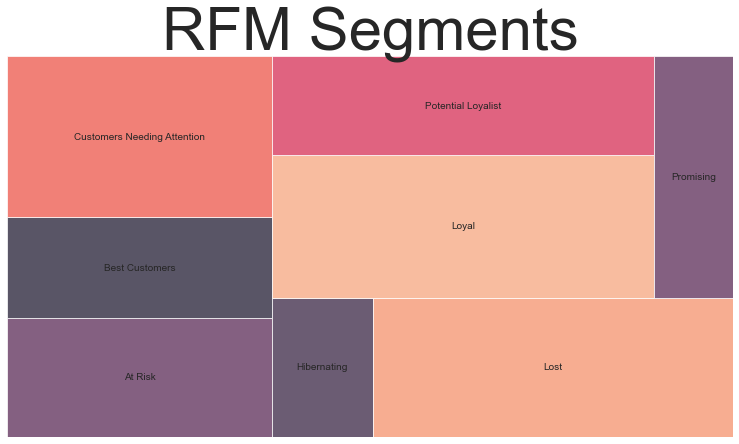

In [24]:
#RFM visualization
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_agg['customerid'], 
              label=['At Risk',
                     'Best Customers',
                     'Customers Needing Attention',
                     'Hibernating',
                     'Lost', 
                     'Loyal', 
                     'Potential Loyalist',
                     'Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=60)
plt.axis('off')
plt.show()

In [26]:
data_set = pd.read_csv('C:/Users/Shiwani Sabnis/PycharmProjects/Data Warehouse/New Test/Online Retail.csv')

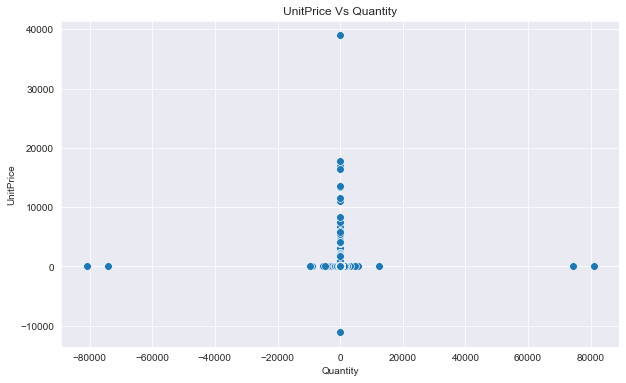

In [27]:
#We take just the UnitPrice Vs Quantity
df1=data_set[["CustomerID","Country","UnitPrice","Quantity","StockCode"]]
X=df1[["UnitPrice","Quantity"]]
#Scatterplot of Annual Income and Spending score
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Quantity',y = 'UnitPrice',  data = X  ,s = 60 )
plt.xlabel('Quantity')
plt.ylabel('UnitPrice') 
plt.title('UnitPrice Vs Quantity')
plt.show()


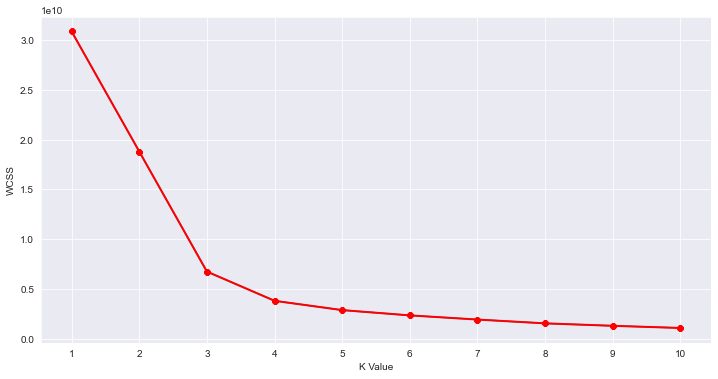

In [28]:
#Importing KMeans from sklearn
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,11):
    km=KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)
#The elbow curve
plt.figure(figsize=(12,6))
plt.plot(range(1,11),wcss)
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

C:\Users\SHIWAN~1\AppData\Local\Temp/ipykernel_20652/3694790756.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["label"] = y


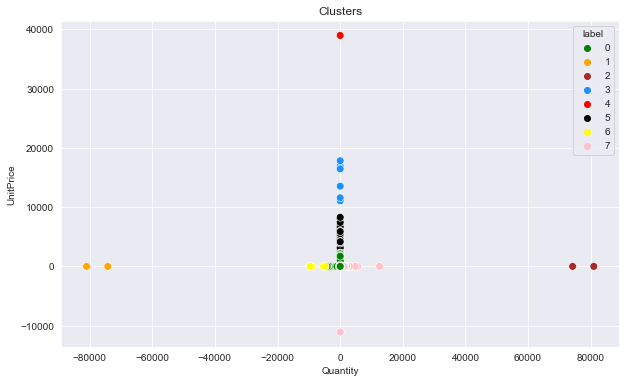

In [29]:
#Taking 8 clusters
km1=KMeans(n_clusters=8)
#Fitting the input data
km1.fit(X)
y=km1.predict(X)
df1["label"] = y
df1.head()

#Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Quantity',y = 'UnitPrice',hue="label",  
                 palette=['green','orange','brown','dodgerblue','red', 'black', 'yellow', 'pink'], legend='full',data = df1  ,s = 60 )
plt.xlabel('Quantity')
plt.ylabel('UnitPrice') 
plt.title('Clusters')
plt.show()

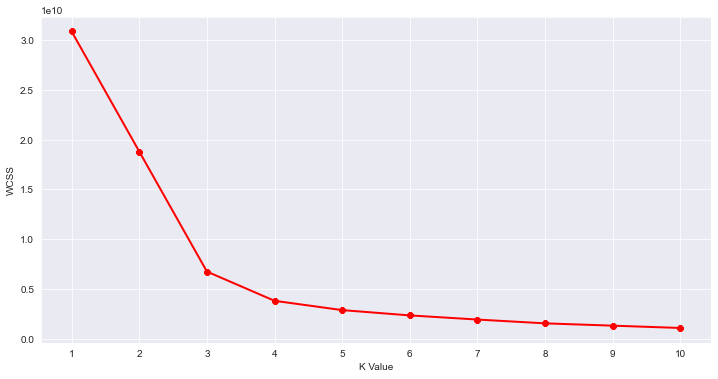

In [31]:
#Taking the features
data_set=data_set[["CustomerID","Country","UnitPrice","Quantity","StockCode"]]
X2=data_set[["UnitPrice","Quantity"]]
#(WSS) for different values of k.
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X2)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [32]:
km2 = KMeans(n_clusters=5)
y2 = km2.fit_predict(X2)
data_set["label"] = y2
#The data with labels
data_set.head()


,CustomerID,Country,UnitPrice,Quantity,StockCode,label
0,17850.0,United Kingdom,2.55,6,85123A,0
1,17850.0,United Kingdom,3.39,6,71053,0
2,17850.0,United Kingdom,2.75,8,84406B,0
3,17850.0,United Kingdom,3.39,6,84029G,0
4,17850.0,United Kingdom,3.39,6,84029E,0


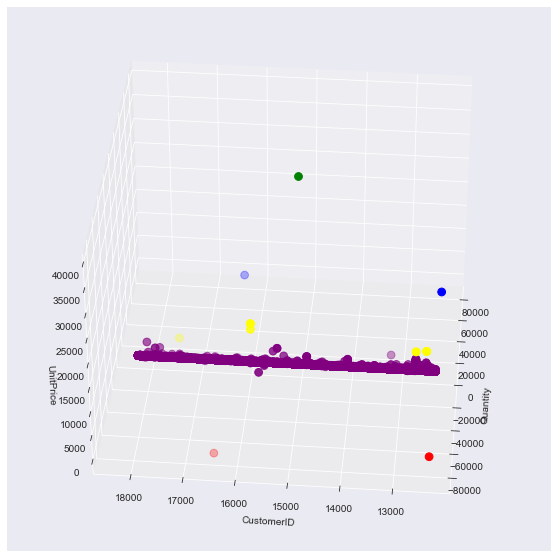

In [34]:
#3D Plot as we did the clustering on the basis of 3 input features
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_set.Quantity[data_set.label == 0], data_set["CustomerID"][data_set.label == 0], data_set["UnitPrice"][data_set.label == 0], c='purple', s=60)
ax.scatter(data_set.Quantity[data_set.label == 1], data_set["CustomerID"][data_set.label == 1], data_set["UnitPrice"][data_set.label == 1], c='red', s=60)
ax.scatter(data_set.Quantity[data_set.label == 2], data_set["CustomerID"][data_set.label == 2], data_set["UnitPrice"][data_set.label == 2], c='blue', s=60)
ax.scatter(data_set.Quantity[data_set.label == 3], data_set["CustomerID"][data_set.label == 3], data_set["UnitPrice"][data_set.label == 3], c='green', s=60)
ax.scatter(data_set.Quantity[data_set.label == 4], data_set["CustomerID"][data_set.label == 4], data_set["UnitPrice"][data_set.label == 4], c='yellow', s=60)
ax.view_init(35, 185)
plt.xlabel("Quantity")
plt.ylabel("CustomerID")
ax.set_zlabel('UnitPrice')
plt.show()